In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import string
from nltk.util import ngrams
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression


In [2]:
import re

In [3]:
RANDOM_SEED = 42 
VAL_SIZE   = 0.2 # train = 0.8

## DATA

Import datasets

In [4]:
train1 = pd.read_csv('all_auto_ru_09_09_2020.csv', low_memory=False) 
train2 = pd.read_csv('all_auto_ru_14_11_2020.csv', low_memory=False)
train3 = pd.read_csv('finalparse.csv') #new parse data from auto.ru


In [5]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
columns_drop = ['Unnamed: 0']
train3 = train3.drop(columns_drop, axis=1)

In [7]:
train1.info(), train2.info(), train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

(None, None, None)

 Обьединяем наши train датасеты 

In [8]:
train = pd.concat([train1, train2,train3])

In [9]:
train

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,equipment_dict,image,model_info,model_name,priceCurrency,sell_id,super_gen,vendor,price_EUR,price_USD
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991.0,SEDAN MECHANICAL 2.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986.0,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989.0,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989.0,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991.0,SEDAN MECHANICAL 2.0,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27562,внедорожник 5 дв.,TOYOTA,чёрный,бензин,2012.0,NaN,5.0,2013.0,NaN,автоматическая,...,NaN,NaN,NaN,RAV_4,NaN,NaN,NaN,NaN,NaN,NaN
27563,внедорожник 5 дв.,TOYOTA,чёрный,бензин,2010.0,NaN,5.0,2011.0,NaN,вариатор,...,NaN,NaN,NaN,RAV_4,NaN,NaN,NaN,NaN,NaN,NaN
27564,внедорожник 5 дв.,TOYOTA,чёрный,бензин,2012.0,NaN,5.0,2013.0,NaN,механическая,...,NaN,NaN,NaN,RAV_4,NaN,NaN,NaN,NaN,NaN,NaN
27565,внедорожник 5 дв.,TOYOTA,чёрный,бензин,2010.0,NaN,5.0,2011.0,NaN,вариатор,...,NaN,NaN,NaN,RAV_4,NaN,NaN,NaN,NaN,NaN,NaN


Удалим дубликаты , а так же строки где много в которых много пропущенных значений

In [10]:
train = train.drop_duplicates()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190418 entries, 0 to 27566
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              190414 non-null  object 
 1   brand                 190418 non-null  object 
 2   color                 190417 non-null  object 
 3   fuelType              190417 non-null  object 
 4   modelDate             190414 non-null  float64
 5   name                  163204 non-null  object 
 6   numberOfDoors         190414 non-null  float64
 7   productionDate        190417 non-null  float64
 8   vehicleConfiguration  163204 non-null  object 
 9   vehicleTransmission   190414 non-null  object 
 10  engineDisplacement    190416 non-null  object 
 11  enginePower           190414 non-null  object 
 12  description           157351 non-null  object 
 13  mileage               190414 non-null  float64
 14  Комплектация          87264 non-null   object 
 15  П

В данном случае у нас есть 37 columns:float64 -10 , object -27.
и есть те где много пропущенных значений.И сразу же удалим такие данные

In [12]:
train.dropna(subset=['price', 'Привод', 'Руль'], inplace=True)

<ipython-input-12-a6ec05661019>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(subset=['price', 'Привод', 'Руль'], inplace=True)


In [13]:
train.isna().sum() ,test.isna().sum()

(bodyType                     0
 brand                        0
 color                        0
 fuelType                     0
 modelDate                    0
 name                     26952
 numberOfDoors                0
 productionDate               0
 vehicleConfiguration     26952
 vehicleTransmission          0
 engineDisplacement           0
 enginePower                  0
 description              32774
 mileage                      0
 Комплектация            102597
 Привод                       0
 Руль                         0
 Состояние               113805
 Владельцы                27691
 ПТС                        808
 Таможня                  26952
 Владение                140859
 price                        0
 start_date               26952
 hidden                  189450
 model                   102597
 complectation_dict      113805
 equipment_dict          113805
 image                   113805
 model_info              113805
 model_name               86856
 priceCu

Тестовый датасет состоит изи 32 признака и 34686 наблюдений.

In [14]:
# for i in test.columns:
#     print(i, len(test[i].value_counts()))


In [15]:
# for i in test.columns:
#     print(i, len(test[test[i].isna()]))

## Предобработка

In [235]:
#Замениим на кириллицу ,чтобы было удобно

In [16]:

orig_or_dupl = {'ORIGINAL':'Оригинал','DUPLICATE':'Дубликат'} 
test['ПТС'] = test['ПТС'].replace(orig_or_dupl)
train['ПТС'] = train['ПТС'].replace(orig_or_dupl)


<ipython-input-16-525b0c79c865>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ПТС'] = train['ПТС'].replace(orig_or_dupl)


In [17]:
train['ПТС'].value_counts()

Оригинал    166136
Дубликат     22506
Name: ПТС, dtype: int64

In [234]:
#заменим на читабельные цвета
colors = {
'040001': 'черный',
'FAFBFB': 'белый',
'97948F': 'серый',
'CACECB': 'серебристый',
'0000CC': 'синий',
'EE1D19': 'красный',
'200204': 'бордовый',
'007F00': 'зелёный',
'C49648': 'коричневый',
'22A0F8': 'голубой',
'DEA522': 'золотистый',
'FFD600': 'жёлтый',
'660099': 'пурпурный',
'4A2197': 'фиолетовый',
'FF8649': 'бежевый',
'FFC0CB': 'розовый',
}

In [19]:
train['color'] = train['color'].replace(colors).apply(lambda x: x.lower())
test['color'] = test['color'].replace(colors).apply(lambda x: x.lower())

<ipython-input-19-e2f2e1ec7082>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['color'] = train['color'].replace(colors).apply(lambda x: x.lower())


In [20]:
train['ПТС'].value_counts(),  test['ПТС'].value_counts()

(Оригинал    166136
 Дубликат     22506
 Name: ПТС, dtype: int64,
 Оригинал    30098
 Дубликат     4587
 Name: ПТС, dtype: int64)

In [236]:
#заменим пропущенное значение у ПТС на наиболее часто встречающий значение


In [21]:
test['ПТС'] = test['ПТС'].fillna('Оригинал')
train['ПТС'] = train['ПТС'].fillna('Оригинал')

<ipython-input-21-3dd45cabaa77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ПТС'] = train['ПТС'].fillna('Оригинал')


In [22]:
train.isna().sum()

bodyType                     0
brand                        0
color                        0
fuelType                     0
modelDate                    0
name                     26952
numberOfDoors                0
productionDate               0
vehicleConfiguration     26952
vehicleTransmission          0
engineDisplacement           0
enginePower                  0
description              32774
mileage                      0
Комплектация            102597
Привод                       0
Руль                         0
Состояние               113805
Владельцы                27691
ПТС                          0
Таможня                  26952
Владение                140859
price                        0
start_date               26952
hidden                  189450
model                   102597
complectation_dict      113805
equipment_dict          113805
image                   113805
model_info              113805
model_name               86856
priceCurrency           113805
sell_id 

In [23]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

Для обучения собрано больше марок автомобилей различного производства. Выделим главных vendor  и остальных обьединяем

<ipython-input-24-695c7b28426a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vendor'] = train['vendor'].fillna('V_UNKNOWN')


<AxesSubplot:>

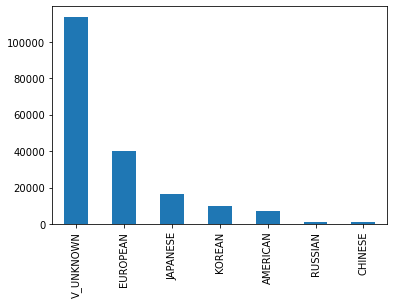

In [24]:
train['vendor'] = train['vendor'].fillna('V_UNKNOWN')
train['vendor'].value_counts().plot.bar()


Удалим сразу признаки, в которых 1 значение - Состояние, Таможня и priceCurrency

In [25]:
columns_drop = ['Состояние', 'Таможня', 'priceCurrency']
train.drop(columns_drop, axis=1, inplace=True)
test.drop(columns_drop, axis=1, inplace=True)

C:\Users\rok05\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Сравним train с test ом .И поменяем признаки на числовой формат  в соответствии с test

In [26]:
train['productionDate'] = train['productionDate'].values.astype('int64')
train['sell_id'] = train['sell_id'].values.astype('int64')
train['modelDate'] = train['modelDate'].values.astype('int64')
train['numberOfDoors'] = train['numberOfDoors'].values.astype('int64')


<ipython-input-26-427cdf149d62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['productionDate'] = train['productionDate'].values.astype('int64')
<ipython-input-26-427cdf149d62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sell_id'] = train['sell_id'].values.astype('int64')
<ipython-input-26-427cdf149d62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189450 entries, 0 to 27566
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              189450 non-null  object 
 1   brand                 189450 non-null  object 
 2   color                 189450 non-null  object 
 3   fuelType              189450 non-null  object 
 4   modelDate             189450 non-null  int64  
 5   name                  162498 non-null  object 
 6   numberOfDoors         189450 non-null  int64  
 7   productionDate        189450 non-null  int64  
 8   vehicleConfiguration  162498 non-null  object 
 9   vehicleTransmission   189450 non-null  object 
 10  engineDisplacement    189450 non-null  object 
 11  enginePower           189450 non-null  object 
 12  description           156676 non-null  object 
 13  mileage               189450 non-null  float64
 14  Комплектация          86853 non-null   object 
 15  П

In [28]:
train['enginePower'].value_counts()

150.0      13486
249.0       7153
140.0       5069
105.0       4119
123.0       3885
           ...  
456 N12        1
79 N12         1
95 N12         1
96 N12         1
460 N12        1
Name: enginePower, Length: 610, dtype: int64

enginePower изменим на тип int

In [29]:
train['enginePower'] = train['enginePower'].apply(lambda x: int(re.findall('(\d+)', str(x))[0]))
test['enginePower'] = test['enginePower'].apply(lambda x: int(re.findall('(\d+)', str(x))[0]))

train['enginePower'] = train['enginePower'].values.astype('int64')
test['enginePower'] = test['enginePower'].values.astype('int64')

<ipython-input-29-d207d1604ab4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['enginePower'] = train['enginePower'].apply(lambda x: int(re.findall('(\d+)', str(x))[0]))
<ipython-input-29-d207d1604ab4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['enginePower'] = train['enginePower'].values.astype('int64')


In [30]:
train.mileage.describe()

count     189450.000000
mean      134819.686181
std       104190.732727
min            0.000000
25%        54557.250000
50%       128000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189450 entries, 0 to 27566
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              189450 non-null  object 
 1   brand                 189450 non-null  object 
 2   color                 189450 non-null  object 
 3   fuelType              189450 non-null  object 
 4   modelDate             189450 non-null  int64  
 5   name                  162498 non-null  object 
 6   numberOfDoors         189450 non-null  int64  
 7   productionDate        189450 non-null  int64  
 8   vehicleConfiguration  162498 non-null  object 
 9   vehicleTransmission   189450 non-null  object 
 10  engineDisplacement    189450 non-null  object 
 11  enginePower           189450 non-null  int64  
 12  description           156676 non-null  object 
 13  mileage               189450 non-null  float64
 14  Комплектация          86853 non-null   object 
 15  П

In [32]:

train['mileage'] = train['mileage'].values.astype('int64')
# и поменяем тип price
train.price = train.price.values.astype('float32')

<ipython-input-32-2cd247cf7830>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mileage'] = train['mileage'].values.astype('int64')
C:\Users\rok05\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
train['mileageNAN'] = train['mileage'].apply(lambda x: 1 if x == 0 else 0)

<ipython-input-33-18810e79d566>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mileageNAN'] = train['mileage'].apply(lambda x: 1 if x == 0 else 0)


#  EDA
bodyType

Сравним bodyType у тест и трейна ,и видим что начальные 9 признаки совпадают

In [34]:
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())

<ipython-input-34-8feb57c3ee93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())


In [35]:
train['bodyType2'] = train.bodyType
bodyType = train.bodyType2.value_counts()[:9]
bodyType

<ipython-input-35-aebd8bce450d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bodyType2'] = train.bodyType


внедорожник 5 дв.    70847
седан                64498
хэтчбек 5 дв.        16480
лифтбек               7306
универсал 5 дв.       7007
минивэн               3608
компактвэн            3523
купе                  2950
хэтчбек 3 дв.         2724
Name: bodyType2, dtype: int64

In [36]:
test['bodyType2'] = test.bodyType

In [37]:
train['bodyType2'] = train['bodyType2'].apply(lambda x: x if x in bodyType else 'other')
test['bodyType2'] = test['bodyType2'].apply(lambda x: x if x in bodyType else 'other')

<ipython-input-37-41887eb0dea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bodyType2'] = train['bodyType2'].apply(lambda x: x if x in bodyType else 'other')


<AxesSubplot:>

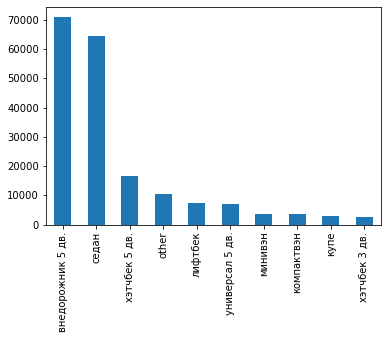

In [38]:
train['bodyType2'].value_counts().plot(kind='bar')

У нас стоимости машины разбросаны, поэтому  построим зависимость от логарифма цены 

In [39]:
train['log_price'] = np.log(train.price)

<ipython-input-39-e06ed8f40ad7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_price'] = np.log(train.price)


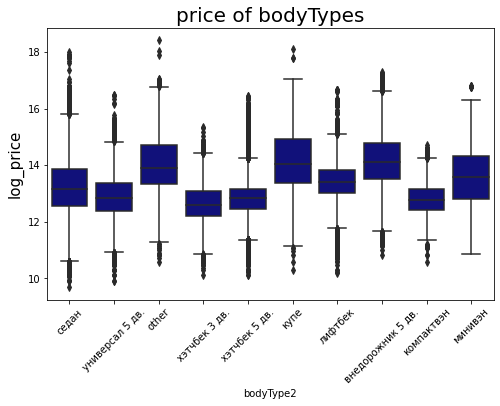

In [40]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bodyType2', 
                  data=train, color='darkblue')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

В целом есть зависимость типа машин от стоимости. Например купе дороговато от остальних

In [41]:
train = train.assign(bT_length = train['bodyType'].apply(len))
test = test.assign(bT_length = test['bodyType'].apply(len))

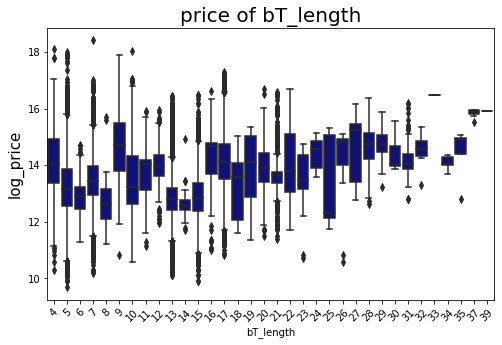

In [42]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bT_length', 
                  data=train, color='darkblue')
g1.set_title("price of bT_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

brand

In [43]:
len(train.brand.value_counts())


36

In [44]:
len(test.brand.value_counts())


12

In [45]:
brand = test.brand.value_counts()
brand

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

Сравним с тестом оставим по брендам с теста , а остальных объединим как otherBrand

In [46]:
train['brand'] = train['brand'].apply(lambda x: x if x in brand else 'otherBrand')

In [47]:
train['brand'].value_counts()

otherBrand    72803
BMW           25008
MERCEDES      19738
VOLKSWAGEN    14890
NISSAN        12591
TOYOTA         9774
AUDI           9433
MITSUBISHI     7915
SKODA          7137
VOLVO          4458
HONDA          2016
LEXUS          1904
INFINITI       1783
Name: brand, dtype: int64

In [48]:
train.groupby('brand').price.describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
AUDI,9433.0,1.522361e+06,1.561084e+06,25000.0,490000.0,999000.0,1949000.00,14898500.0
BMW,25008.0,2.089680e+06,2.117576e+06,45000.0,680000.0,1349000.0,2915250.00,16290000.0
HONDA,2016.0,6.297659e+05,5.336129e+05,40000.0,323750.0,488000.0,780000.00,5697338.0
INFINITI,1783.0,1.575364e+06,1.153766e+06,105000.0,739500.0,1290000.0,1890000.00,6849262.0
LEXUS,1904.0,2.160016e+06,1.515721e+06,65000.0,970000.0,1799999.5,3019500.00,13000000.0
MERCEDES,19738.0,3.993091e+06,4.282492e+06,40000.0,1050000.0,2898900.0,5344400.00,72000000.0
MITSUBISHI,7915.0,9.034123e+05,7.729298e+05,38000.0,280000.0,599999.0,1455500.00,3572805.0
NISSAN,12591.0,8.762658e+05,6.512968e+05,25000.0,400000.0,685000.0,1200000.00,7900000.0
SKODA,7137.0,7.478966e+05,5.043372e+05,20000.0,439000.0,615000.0,899000.00,3180000.0


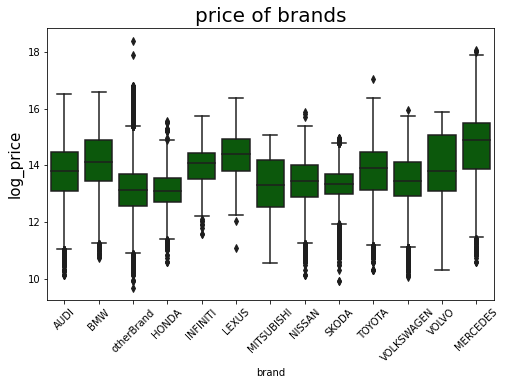

In [49]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand', 
                  data=train, color='darkgreen')
g1.set_title("price of brands", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [50]:
train = train.assign(brand_length = train['brand'].apply(len))
test = test.assign(brand_length = test['brand'].apply(len))

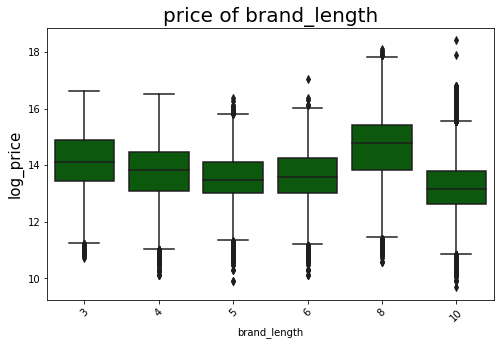

In [51]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand_length', 
                  data=train, color='darkgreen')
g1.set_title("price of brand_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [52]:
len(test.model_name.value_counts())

544

In [53]:
len(train.model_name.value_counts())

1066

In [54]:
test.model_name.value_counts().head(15)

OCTAVIA      1418
5ER          1026
LANCER        855
E_KLASSE      809
PASSAT        782
A6            757
3ER           752
POLO          724
CAMRY         709
X5            675
X_TRAIL       654
A4            626
QASHQAI       609
S_KLASSE      549
OUTLANDER     544
Name: model_name, dtype: int64

In [55]:
test.complectation_dict.isna().sum()

28268

In [56]:
train.complectation_dict.value_counts().head(3)

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [57]:
test.complectation_dict.value_counts().head(3)

{"id":"4562904","name":"Elegance","available_options":["cruise-control","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","alarm","ptf","rain-sensor","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [58]:
test.equipment_dict.value_counts().head(10)

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           108
{"gbo":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [59]:
train.equipment_dict.value_counts().head(10)

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [60]:
train.isna().sum()

bodyType                     0
brand                        0
color                        0
fuelType                     0
modelDate                    0
name                     26952
numberOfDoors                0
productionDate               0
vehicleConfiguration     26952
vehicleTransmission          0
engineDisplacement           0
enginePower                  0
description              32774
mileage                      0
Комплектация            102597
Привод                       0
Руль                         0
Владельцы                27691
ПТС                          0
Владение                140859
price                        0
start_date               26952
hidden                  189450
model                   102597
complectation_dict      113805
equipment_dict          113805
image                   113805
model_info              113805
model_name               86856
sell_id                      0
super_gen               113805
vendor                       0
price_EU

In [61]:
train['model_name'] = train['model_name'].fillna(train['model'])

In [62]:
train.model_info[4]

4                                                  NaN
4    {'code': '100', 'name': '100', 'ru_name': '100...
4                                                  NaN
Name: model_info, dtype: object

In [63]:
test.model_info[4]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [64]:
test.equipment_dict.value_counts().head(10)

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           108
{"gbo":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [65]:
train.equipment_dict.value_counts().head(10)


{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [66]:
test.name[:100]

0         1.2 AMT (105 л.с.)
1          1.6 MT (110 л.с.)
2     DSG 1.8 AMT (152 л.с.)
3          1.6 AT (110 л.с.)
4          1.8 AT (152 л.с.)
               ...          
95    1.8 AMT (152 л.с.) 4WD
96         1.6 MT (102 л.с.)
97         1.6 AT (110 л.с.)
98         1.4 MT (140 л.с.)
99        1.4 AMT (150 л.с.)
Name: name, Length: 100, dtype: object

<AxesSubplot:>

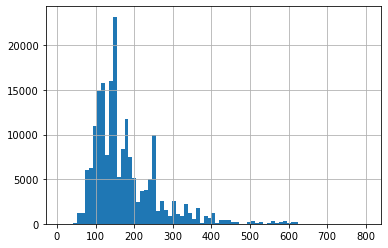

In [67]:
train['enginePower'].hist(bins=77)

In [68]:
train.enginePower.describe()

count    189450.000000
mean        176.551903
std          85.820272
min          11.000000
25%         117.000000
50%         150.000000
75%         210.000000
max         800.000000
Name: enginePower, dtype: float64

In [69]:
train['log_power'] = np.log(train.enginePower)

<AxesSubplot:>

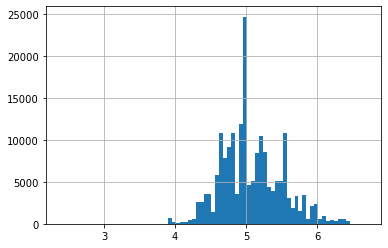

In [70]:
train['log_power'].hist(bins=77)

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189450 entries, 0 to 27566
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              189450 non-null  object 
 1   brand                 189450 non-null  object 
 2   color                 189450 non-null  object 
 3   fuelType              189450 non-null  object 
 4   modelDate             189450 non-null  int64  
 5   name                  162498 non-null  object 
 6   numberOfDoors         189450 non-null  int64  
 7   productionDate        189450 non-null  int64  
 8   vehicleConfiguration  162498 non-null  object 
 9   vehicleTransmission   189450 non-null  object 
 10  engineDisplacement    189450 non-null  object 
 11  enginePower           189450 non-null  int64  
 12  description           156676 non-null  object 
 13  mileage               189450 non-null  int64  
 14  Комплектация          86853 non-null   object 
 15  П

In [72]:
bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
numbers = ['5000','12','25','35', '45', '50', '65', '75', '150']

In [73]:
train['Nalog_base']=pd.cut(train['enginePower'],bins,labels=numbers)
test['Nalog_base']=pd.cut(test['enginePower'],bins,labels=numbers)


In [74]:
train['Nalog_base'] = train['Nalog_base'].values.astype('int64')
test['Nalog_base'] = test['Nalog_base'].values.astype('int64')

In [75]:
train['Nalog_base']

0        45
1        12
2        35
3        12
4        25
         ..
27562    50
27563    35
27564    35
27565    35
27566    45
Name: Nalog_base, Length: 189450, dtype: int64

In [76]:
test['enginePower'] = test['enginePower'].astype(float)

In [77]:
test.enginePower.describe()

count    34686.000000
mean       188.194142
std         89.087035
min         30.000000
25%        125.000000
50%        169.000000
75%        233.000000
max        639.000000
Name: enginePower, dtype: float64

In [78]:
test['log_power'] = np.log(test.enginePower)


In [79]:
bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
numbers = ['5000','12','25','35', '45', '50', '65', '75', '150']

In [80]:
train['Nalog_base']=pd.cut(train['enginePower'],bins,labels=numbers)
test['Nalog_base']=pd.cut(test['enginePower'],bins,labels=numbers)
train['Nalog_base'] = train['Nalog_base'].values.astype('int64')
test['Nalog_base'] = test['Nalog_base'].values.astype('int64')

In [81]:
train['Nalog'] = train['enginePower'] * train['Nalog_base']
test['Nalog'] = test['enginePower'] * test['Nalog_base']

In [82]:
train['Nalog'] 

0        7830
1        1080
2        4760
3        1080
4        2525
         ... 
27562    8950
27563    5180
27564    5110
27565    5180
27566    7110
Name: Nalog, Length: 189450, dtype: int64

In [83]:
test['Nalog']

0         2625.0
1         2750.0
2         6840.0
3         2750.0
4         6840.0
          ...   
34681     4760.0
34682     9500.0
34683     7650.0
34684     9200.0
34685    17625.0
Name: Nalog, Length: 34686, dtype: float64

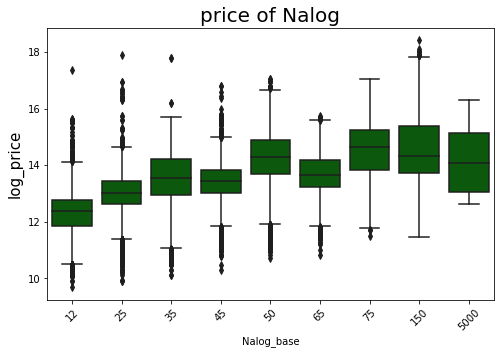

In [84]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Nalog_base', 
                  data=train, color='darkgreen')
g1.set_title("price of Nalog", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

<AxesSubplot:xlabel='Nalog'>

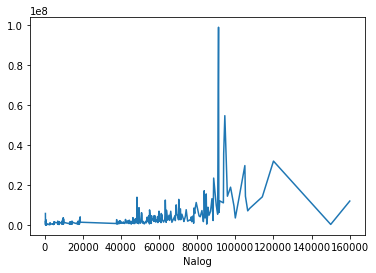

In [85]:
train.groupby('Nalog').price.mean().plot()


In [86]:
train.engineDisplacement.value_counts()

1.6         32135
2.0         27700
1.4         10290
1.8          9597
2.0 LTR      7805
            ...  
Soft            1
Electric        1
Easy            1
Plus            1
8.4             1
Name: engineDisplacement, Length: 590, dtype: int64

In [87]:
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x[:3])
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:3])

In [88]:
train['engineDisplacement'].value_counts().head(40)

2.0    41784
1.6    35655
3.0    13959
1.8    11921
1.4    11500
2.5     9593
2.4     7382
1.5     5399
3.5     3463
4.4     2022
2.2     1979
1.3     1977
1.2     1885
2.3     1823
200     1504
1.7     1486
350     1436
2.9     1409
2.7     1270
4.0     1221
3.6     1136
2.8     1127
320     1092
3.2     1065
4.5      933
1.9      756
4.2      675
520      662
300      661
4.7      659
2.1      653
0.8      619
250      581
500      568
450      501
4.8      498
30d      483
180      472
400      463
6.2      462
Name: engineDisplacement, dtype: int64

In [89]:
train[train['engineDisplacement'] == 'S4']

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,price_EUR,price_USD,mileageNAN,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
45,седан,AUDI,черный,бензин,1990,S4 2.2 AT (230 л.с.) 4WD,4,1992,SEDAN AUTOMATIC S4,AUTOMATIC,...,NaN,NaN,0,седан,12.301383,5,4,5.438079,75,17250
63640,седан,otherBrand,серебристый,бензин,2014,S4 2.0 CVT (300 л.с.) 4WD,4,2014,SEDAN VARIATOR S4,VARIATOR,...,NaN,NaN,0,седан,14.187074,5,10,5.703782,150,45000


In [90]:
len(test[test['engineDisplacement'] == ' LT'])

55

In [91]:
train[train['engineDisplacement'] == ' LT']

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,price_EUR,price_USD,mileageNAN,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
15011,хэтчбек 5 дв.,BMW,серый,электро,2013,NaN,5,2017,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.403297,13,3,5.135798,45,7650
15013,хэтчбек 5 дв.,BMW,синий,электро,2017,NaN,5,2017,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.557447,13,3,5.214936,50,9200
15019,хэтчбек 5 дв.,BMW,серый,электро,2017,NaN,5,2018,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.483340,13,3,5.135798,45,7650
15022,хэтчбек 5 дв.,BMW,чёрный,электро,2013,NaN,5,2015,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,13.864301,13,3,5.135798,45,7650
15029,хэтчбек 5 дв.,BMW,белый,электро,2013,NaN,5,2016,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,13.955273,13,3,5.135798,45,7650
15031,хэтчбек 5 дв.,BMW,серый,электро,2013,NaN,5,2014,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.508657,13,3,5.135798,45,7650
15032,хэтчбек 5 дв.,BMW,чёрный,электро,2013,NaN,5,2014,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.247293,13,3,5.135798,45,7650
15033,хэтчбек 5 дв.,BMW,красный,электро,2013,NaN,5,2014,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.124465,13,3,5.135798,45,7650
15038,хэтчбек 5 дв.,BMW,чёрный,электро,2013,NaN,5,2015,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,13.955273,13,3,5.135798,45,7650
15041,хэтчбек 5 дв.,BMW,синий,электро,2017,NaN,5,2018,NaN,автоматическая,...,NaN,NaN,0,хэтчбек 5 дв.,14.815775,13,3,5.214936,50,9200


In [92]:
train.groupby('engineDisplacement').enginePower.describe().head(20)

,count,mean,std,min,25%,50%,75%,max
engineDisplacement,,,,,,,,
LT,13.0,167.923077,16.735499,115.0,170.0,170.0,170.0,184.0
+,1.0,75.000000,NaN,75.0,75.0,75.0,75.0,75.0
0.6,8.0,173.500000,6.480741,170.0,170.0,170.0,173.5,184.0
0.7,166.0,75.843373,44.254356,45.0,52.0,58.0,64.0,184.0
0.8,619.0,51.767367,1.667557,38.0,52.0,52.0,52.0,52.0
1.0,384.0,64.705729,6.846651,42.0,60.0,67.0,68.0,125.0
1.1,144.0,65.090278,8.006914,30.0,64.0,66.0,68.0,101.0
1.2,1885.0,89.402653,16.469804,44.0,75.0,85.0,105.0,116.0
1.3,1977.0,107.830046,39.059612,40.0,82.0,88.0,150.0,255.0


In [93]:
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: 1.6 if x == ' LT' else x)
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 1.6 if x == ' LT' else x)

In [94]:
train['engineDisplacement'].value_counts()[:36].keys()

Index(['2.0', '1.6', '3.0', '1.8', '1.4', '2.5', '2.4', '1.5', '3.5', '4.4',
       '2.2', '1.3', '1.2', '2.3', '200', '1.7', '350', '2.9', '2.7', '4.0',
       '3.6', '2.8', '320', '3.2', '4.5', '1.9', '4.2', '520', '300', '4.7',
       '2.1', '0.8', '250', '500', '450', '4.8'],
      dtype='object')

In [95]:
brand_list = list(train['engineDisplacement'].value_counts()[:36].keys())
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x if x in brand_list else 1.8)


<AxesSubplot:>

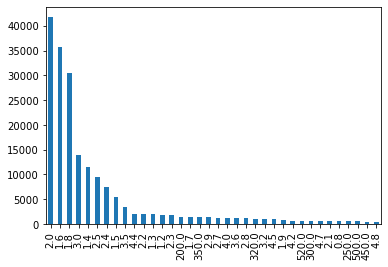

In [96]:
train['engineDisplacement'] = train['engineDisplacement'].astype('float')
train['engineDisplacement'].value_counts().plot(kind='bar')

In [97]:
test.vehicleTransmission.value_counts()


автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [98]:
train.vehicleTransmission.value_counts()


AUTOMATIC           89663
MECHANICAL          46066
автоматическая      17296
ROBOT               14829
VARIATOR            11940
механическая         4478
роботизированная     2604
вариатор             2574
Name: vehicleTransmission, dtype: int64

In [99]:
vehicle = {'AUTOMATIC':'автоматическая',
'MECHANICAL':'механическая',
'ROBOT':'роботизированная',
'VARIATOR':'вариатор'}
train['vehicleTransmission'] = train['vehicleTransmission'].replace(vehicle)

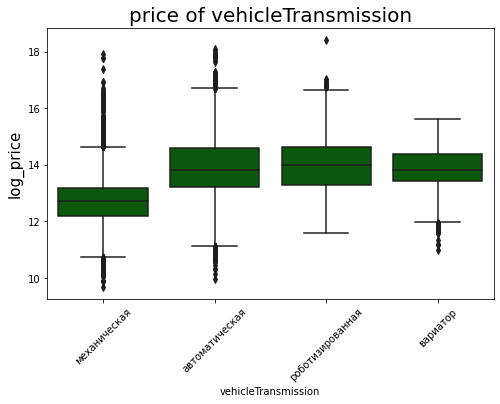

In [100]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='vehicleTransmission', 
                  data=train, color='darkgreen')
g1.set_title("price of vehicleTransmission", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [101]:
train.vehicleConfiguration[676]

676       SEDAN ROBOT 2.0
676    SEDAN VARIATOR 1.8
676                   NaN
Name: vehicleConfiguration, dtype: object

In [102]:
test[test.numberOfDoors == 0] 

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владение,ПТС,Привод,Руль,bodyType2,bT_length,brand_length,Nalog_base,log_power,Nalog
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,...,6 лет и 8 месяцев,Оригинал,задний,Правый,other,9,8,5000,3.465736,160000.0


In [103]:
train[train.numberOfDoors == 0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,price_EUR,price_USD,mileageNAN,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
88065,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,...,NaN,NaN,0,other,16.300417,9,8,3.465736,5000,160000
76332,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,...,131403.0,155187.0,0,other,16.300417,9,8,3.465736,5000,160000


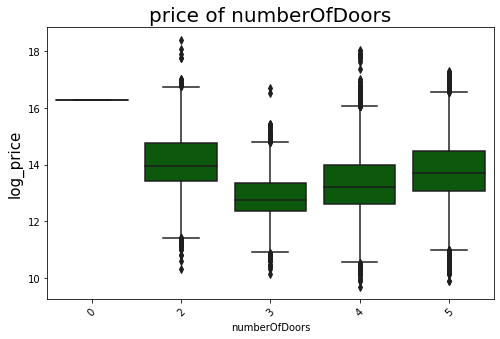

In [104]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='numberOfDoors', 
                  data=train, color='darkgreen')
g1.set_title("price of numberOfDoors", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [105]:
display(pd.DataFrame(train.color.value_counts()))

,color
черный,45447
белый,33726
серый,23262
серебристый,22608
синий,19346
красный,9649
чёрный,9198
бордовый,6582
зелёный,5357
коричневый,4597


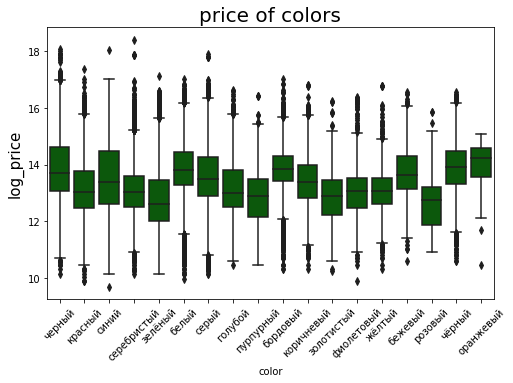

In [106]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='color', 
                  data=train, color='darkgreen')
g1.set_title("price of colors", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [107]:
train['years_old'] = 2021 - train['productionDate']
test['years_old'] = 2021 - test['productionDate']

<AxesSubplot:>

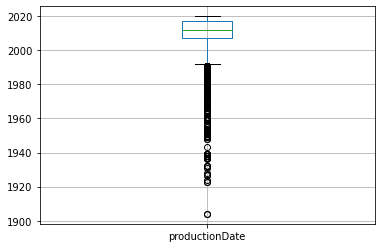

In [108]:
train.boxplot(column=['productionDate'])


In [109]:
train[train.productionDate < 1940]


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,price_USD,mileageNAN,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog,years_old
303,седан,AUDI,черный,бензин,1938,3.3 MT (75 л.с.),4,1938,SEDAN MECHANICAL 3.3,механическая,...,NaN,0,седан,14.508657,5,4,4.317488,12,900,83
5862,седан 2 дв.,BMW,белый,бензин,1937,2.0 MT (46 л.с.),2,1937,SEDAN_2_DOORS MECHANICAL 2.0,механическая,...,NaN,0,other,13.815511,11,3,3.828641,12,552,84
5865,седан 2 дв.,BMW,черный,бензин,1937,2.0 MT (46 л.с.),2,1937,SEDAN_2_DOORS MECHANICAL 2.0,механическая,...,NaN,0,other,14.508657,11,3,3.828641,12,552,84
5866,седан,BMW,коричневый,бензин,1936,2.0 MT (51 л.с.),4,1938,SEDAN MECHANICAL 2.0,механическая,...,NaN,0,седан,12.994530,5,3,3.931826,12,612,83
5867,седан,BMW,коричневый,бензин,1936,2.0 MT (51 л.с.),4,1937,SEDAN MECHANICAL 2.0,механическая,...,NaN,0,седан,14.346139,5,3,3.931826,12,612,84
22688,хэтчбек 3 дв.,otherBrand,пурпурный,бензин,1927,3.3 MT (40 л.с.),3,1931,HATCHBACK_3_DOORS MECHANICAL 3.3,механическая,...,NaN,0,хэтчбек 3 дв.,15.363884,13,10,3.688879,12,480,90
22689,хэтчбек 3 дв.,otherBrand,синий,бензин,1927,3.3 MT (40 л.с.),3,1927,HATCHBACK_3_DOORS MECHANICAL 3.3,механическая,...,NaN,0,хэтчбек 3 дв.,15.319588,13,10,3.688879,12,480,94
22690,хэтчбек 3 дв.,otherBrand,черный,бензин,1927,3.3 MT (40 л.с.),3,1927,HATCHBACK_3_DOORS MECHANICAL 3.3,механическая,...,NaN,0,хэтчбек 3 дв.,14.808763,13,10,3.688879,12,480,94
22691,кабриолет,otherBrand,зелёный,бензин,1908,2.9 MT (20 л.с.),2,1923,CABRIO MECHANICAL 2.9,механическая,...,NaN,0,other,15.150512,9,10,2.995732,5000,100000,98
22692,кабриолет,otherBrand,черный,бензин,1908,2.9 MT (20 л.с.),2,1924,CABRIO MECHANICAL 2.9,механическая,...,NaN,0,other,14.914123,9,10,2.995732,5000,100000,97


In [110]:
train.years_old.value_counts().head(10)

1     27158
13    13807
9     13523
10    12527
8     11904
14    10703
7     10024
11     9061
4      7577
6      7505
Name: years_old, dtype: int64

In [111]:
test[test.productionDate <=1980].productionDate

771      1976
1777     1939
3174     1938
4610     1980
6568     1978
7216     1970
7256     1979
7774     1977
8348     1972
8531     1975
8627     1969
9143     1950
9373     1953
9495     1949
9625     1937
9819     1937
11764    1980
11788    1979
15806    1969
15808    1959
16386    1975
16665    1968
16844    1976
16891    1936
16944    1904
17043    1974
17067    1967
17341    1978
17350    1961
17427    1976
17440    1977
17448    1980
17639    1960
17643    1959
17653    1965
17796    1953
17993    1963
18014    1957
18070    1980
18129    1959
18185    1952
19001    1980
19223    1980
21568    1979
21602    1977
24393    1973
24597    1965
24732    1973
24883    1972
26486    1972
30324    1980
31400    1980
33748    1948
34193    1978
Name: productionDate, dtype: int64

In [112]:
train.years_old.describe()

count    189450.000000
mean         10.007596
std           7.124517
min           1.000000
25%           4.000000
50%           9.000000
75%          14.000000
max         117.000000
Name: years_old, dtype: float64

In [113]:
test.years_old.describe()


count    34686.000000
mean        11.735398
std          7.047661
min          1.000000
25%          7.000000
50%         10.000000
75%         15.000000
max        117.000000
Name: years_old, dtype: float64

In [114]:
bins = [-1, 3, 7, 13, 20, 35, 117]
numbers = ['3', '7','13','20','35', '117']

train['age_intervals']=pd.cut(train['years_old'],bins,labels=numbers)
test['age_intervals']=pd.cut(test['years_old'],bins,labels=numbers)

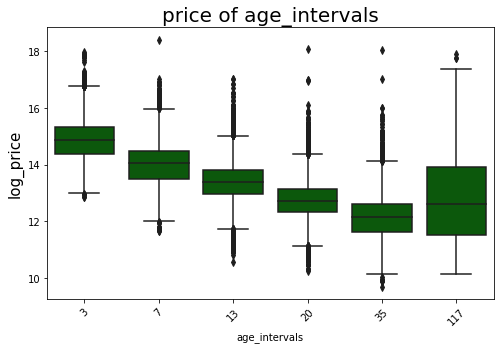

In [115]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='age_intervals', 
                  data=train, color='darkgreen')
g1.set_title("price of age_intervals", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [116]:
train.modelDate.describe()

count    189450.000000
mean       2008.745796
std           7.529783
min        1904.000000
25%        2005.000000
50%        2010.000000
75%        2014.000000
max        2020.000000
Name: modelDate, dtype: float64

In [117]:
test.modelDate.describe()

count    34686.000000
mean      2007.074728
std          7.415894
min       1904.000000
25%       2004.000000
50%       2008.000000
75%       2012.000000
max       2020.000000
Name: modelDate, dtype: float64

In [118]:
train.modelDate.value_counts().head(20)

2010    12194
2006    12108
2009    11305
2018    10616
2017    10546
2011    10078
2012     9621
2005     9289
2007     8698
2008     8520
2013     8482
2014     8423
2015     8378
2016     7203
2002     6335
2019     6314
2004     6009
2000     5234
2003     4053
2020     3724
Name: modelDate, dtype: int64

In [119]:
train['Владельцы'].isna().sum()

27691

In [130]:
train.Владельцы.value_counts()

3.0    75546
2.0    43590
1.0    42623
Name: Владельцы, dtype: int64

In [125]:
test.Владельцы.value_counts()

3    15957
1     9459
2     9270
Name: Владельцы, dtype: int64

<AxesSubplot:>

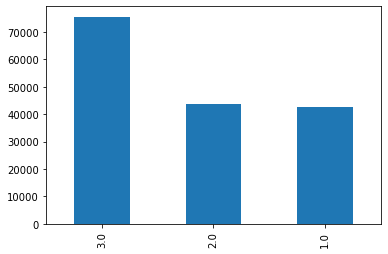

In [174]:
# data['Владельцы'] = data['Владельцы'].fillna(data['Владельцы'].describe().top)
train['Владельцы']= train['Владельцы'].astype('category')
train['Владельцы'].value_counts().plot(kind='bar')


In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189450 entries, 0 to 27566
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   brand                189450 non-null  object  
 1   color                189450 non-null  object  
 2   fuelType             189450 non-null  object  
 3   modelDate            189450 non-null  int64   
 4   numberOfDoors        189450 non-null  int64   
 5   productionDate       189450 non-null  int64   
 6   vehicleTransmission  189450 non-null  object  
 7   engineDisplacement   189450 non-null  float64 
 8   enginePower          189450 non-null  int64   
 9   mileage              189450 non-null  int64   
 10  Комплектация         86853 non-null   object  
 11  Привод               189450 non-null  object  
 12  Руль                 189450 non-null  object  
 13  Владельцы            161759 non-null  category
 14  ПТС                  189450 non-null  object  
 15  p

In [128]:
train['Владельцы']= train['Владельцы'].apply(lambda x: int(re.findall('\d', str(x))[0]))

<AxesSubplot:>

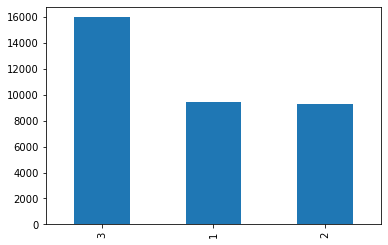

In [129]:
# data['Владельцы'] = data['Владельцы'].fillna(data['Владельцы'].describe().top)
test['Владельцы']= test['Владельцы'].apply(lambda x: int(re.findall('\d', str(x))[0]))
test['Владельцы']= test['Владельцы'].astype('category')
test['Владельцы'].value_counts().plot(kind='bar')


In [ ]:
train['Владельцы'] = train['Владельцы'].astype("category")

In [131]:
# train.Владельцы = train.Владельцы.apply(lambda x: x[0])

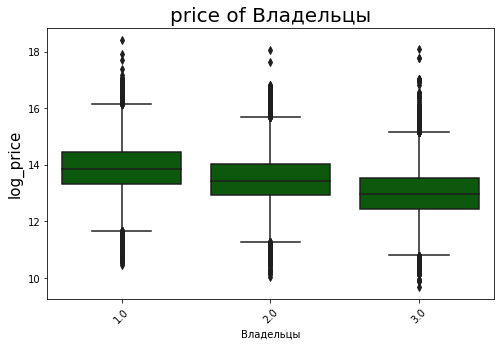

In [132]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Владельцы', 
                  data=train, color='darkgreen')
g1.set_title("price of Владельцы", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [133]:
train.Владение.isna().sum()

140859

In [134]:
test.Владение.isna().sum()

22691

In [135]:
train.Владение

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
27562    NaN
27563    NaN
27564    NaN
27565    NaN
27566    NaN
Name: Владение, Length: 189450, dtype: object

In [136]:
train.groupby('Владельцы').Владение.describe()

,count,unique,top,freq
Владельцы,,,,
1.0,12659,265,"{'year': 2018, 'month': 12}",191
2.0,13509,261,"{'year': 2018, 'month': 11}",237
3.0,22423,262,"{'year': 2019, 'month': 8}",503


In [137]:
test.Руль.value_counts(), train.Руль.value_counts()

(Левый     33287
 Правый     1399
 Name: Руль, dtype: int64,
 LEFT      159327
 Левый      26850
 RIGHT       3171
 Правый       102
 Name: Руль, dtype: int64)

In [138]:
test.Руль.value_counts(), train.Руль.value_counts()

(Левый     33287
 Правый     1399
 Name: Руль, dtype: int64,
 LEFT      159327
 Левый      26850
 RIGHT       3171
 Правый       102
 Name: Руль, dtype: int64)

<AxesSubplot:>

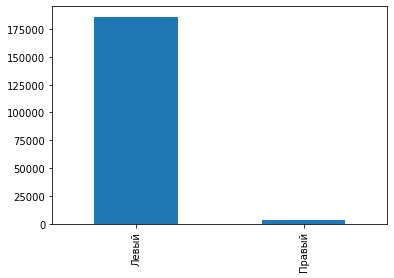

In [139]:
rule={'LEFT': 'Левый', 'RIGHT': 'Правый' }
train['Руль'] = train['Руль'].replace(rule)
train['Руль'].value_counts().plot.bar()

In [140]:
train.Руль.value_counts()

Левый     186177
Правый      3273
Name: Руль, dtype: int64

In [141]:
train.ПТС.value_counts()

Оригинал    166944
Дубликат     22506
Name: ПТС, dtype: int64

In [142]:
train.sell_id.nunique()

75497

<AxesSubplot:>

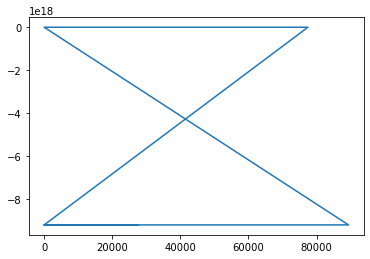

In [143]:
train['sell_id'].plot()


In [144]:
train.fuelType.value_counts()

бензин     156426
дизель      32216
гибрид        561
электро       214
газ            33
Name: fuelType, dtype: int64

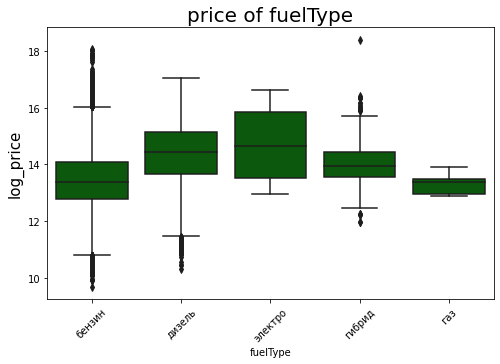

In [145]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='fuelType', 
                  data=train, color='darkgreen')
g1.set_title("price of fuelType", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

In [146]:
test.super_gen[2]

'{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 л.с.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'

In [147]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [148]:
train.vendor.value_counts()

V_UNKNOWN    113805
EUROPEAN      40010
JAPANESE      16513
KOREAN         9666
AMERICAN       7359
RUSSIAN        1057
CHINESE        1040
Name: vendor, dtype: int64

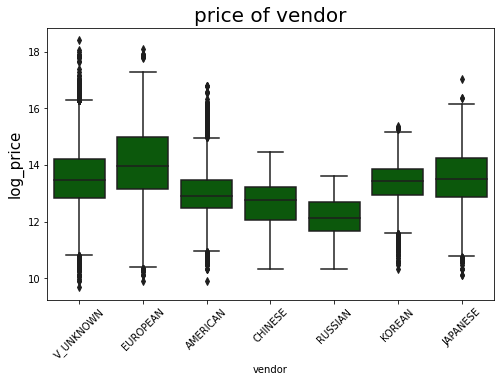

In [149]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='vendor', 
                  data=train, color='darkgreen')
g1.set_title("price of vendor", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

In [150]:
train.mileage.describe()

count     189450.000000
mean      134819.686181
std       104190.732727
min            0.000000
25%        54557.250000
50%       128000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [151]:
train[train.mileage == 0].groupby('years_old').price.describe()

,count,mean,std,min,25%,50%,75%,max
years_old,,,,,,,,
1,26047.0,4028284.5,3125711.5,627000.0,1910500.0,3140000.0,4930000.0,65435792.0
2,1540.0,6147283.5,4370824.5,871900.0,2532000.0,4061500.0,9041330.0,20770330.0
3,101.0,14188302.0,19478218.0,899900.0,4725000.0,6570070.0,7850000.0,59087576.0
4,1.0,3829900.0,NaN,3829900.0,3829900.0,3829900.0,3829900.0,3829900.0


In [152]:
train.groupby('years_old').mileage.mean().head(10)


years_old
1        213.092385
2      18403.334926
3      47200.056068
4      69564.483173
5      88291.237989
6     100859.797868
7     115074.663508
8     126701.015121
9     136808.279672
10    147303.774248
Name: mileage, dtype: float64

In [153]:
train['mileageNAN'] = train.mileageNAN * (train.years_old * 20000 + 10000)

In [154]:
train.mileage = train.mileage + train.mileageNAN


In [155]:
train.mileage.describe()

count     189450.000000
mean      139388.543399
std        98740.065094
min            1.000000
25%        55000.000000
50%       128000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [156]:
train.groupby('years_old').mileage.mean().head(10)


years_old
1      28985.829700
2      31088.672652
3      48251.513534
4      69576.361225
5      88291.237989
6     100859.797868
7     115074.663508
8     126701.015121
9     136808.279672
10    147303.774248
Name: mileage, dtype: float64

In [157]:
train[train.mileage == 1].productionDate

18051    2005
24788    2019
24789    2019
42002    2019
53666    1996
59535    2014
83747    2020
83820    2020
85056    2020
86843    2020
88166    2020
88167    2020
88210    2020
88213    2020
88290    2020
88291    2019
88305    2020
88440    2008
88652    1936
45944    1956
56361    2020
70389    2020
70483    2020
76421    2020
76528    2020
76546    2020
76548    2020
76561    2020
76584    2020
8513     2020
8558     2020
8563     2020
11683    1990
15948    2020
26081    2020
Name: productionDate, dtype: int64

In [158]:
train['mileage'] = train['mileage'].apply(lambda x: 1000 if x <100 else x)
test['mileage'] = test['mileage'].apply(lambda x: 1000 if x < 100 else x)

In [159]:
train.mileage.describe()

count     189450.000000
mean      139390.589945
std        98737.186616
min          100.000000
25%        55000.000000
50%       128000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [160]:
test.Привод.value_counts()

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

In [161]:
train.Привод.value_counts()

передний    92266
полный      78108
задний      19076
Name: Привод, dtype: int64

In [162]:
train.price.describe()

count      189450.00
mean      1451297.25
std       2125309.75
min         16000.00
25%        390000.00
50%        750000.00
75%       1650000.00
max      99000000.00
Name: price, dtype: float64

<AxesSubplot:>

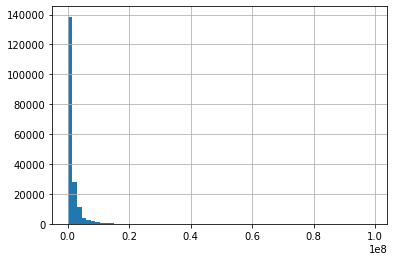

In [163]:
train['price'].hist(bins=66)

<AxesSubplot:>

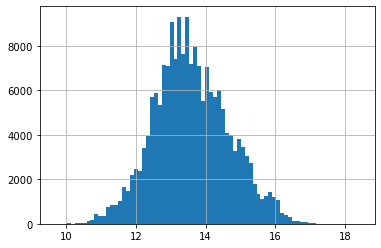

In [164]:
train['log_price'].hist(bins=77)

In [165]:
# train.info()

Удаляем не нужные колонки 

In [166]:
columns_drop1 = ['model_info', 'name', 'car_url', 'sell_id', 'complectation_dict', 'equipment_dict',
                'vehicleConfiguration','Владение', 'image', 'parsing_unixtime', 'super_gen',
                'description', 'bodyType', 'log_power']

In [167]:
columns_drop2 = ['model_info', 'name', 'sell_id', 'complectation_dict', 'equipment_dict',
                'vehicleConfiguration','Владение', 'image', 'super_gen',
                'description', 'bodyType', 'log_power']

In [168]:
test.drop(columns_drop1, axis=1, inplace=True)

In [169]:
train.drop(columns_drop2, axis=1, inplace=True)

In [170]:
train[train['Владельцы'].isna()]

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,...,price_USD,mileageNAN,bodyType2,log_price,bT_length,brand_length,Nalog_base,Nalog,years_old,age_intervals
332,AUDI,серый,бензин,2016,4,2020,роботизированная,1.4,150,30000,...,NaN,30000,седан,14.449651,5,4,35,5250,1,3
333,AUDI,серебристый,бензин,2016,4,2020,роботизированная,1.4,150,30000,...,NaN,30000,седан,14.449651,5,4,35,5250,1,3
336,AUDI,синий,бензин,2016,4,2020,роботизированная,1.4,150,30000,...,NaN,30000,седан,14.449651,5,4,35,5250,1,3
339,AUDI,синий,бензин,2016,4,2020,роботизированная,1.4,150,30000,...,NaN,30000,седан,14.516626,5,4,35,5250,1,3
342,AUDI,серый,бензин,2016,4,2020,роботизированная,1.4,150,30000,...,NaN,30000,седан,14.481287,5,4,35,5250,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76707,MERCEDES,черный,дизель,2014,4,2020,автоматическая,2.1,190,30000,...,62282.0,30000,other,15.387454,10,8,50,9500,1,3
76710,MERCEDES,серый,дизель,2014,4,2020,автоматическая,2.1,190,30000,...,63135.0,30000,other,15.401066,10,8,50,9500,1,3
76715,MERCEDES,черный,дизель,2014,4,2020,автоматическая,2.1,190,30000,...,64724.0,30000,other,15.425920,10,8,50,9500,1,3
15737,BMW,красный,бензин,2007,5,2008,автоматическая,1.6,115,150000,...,NaN,0,хэтчбек 5 дв.,13.122363,13,3,25,2875,13,13


In [171]:
train.drop(columns = ['mileageNAN'], axis=1, inplace=True)

In [176]:
train['Владельцы'] = train['Владельцы'].fillna(train['Владельцы'].describe().top)

In [177]:
train['model_name'] = train['model_name'].fillna(train['model_name'].describe().top)

In [178]:
train.drop(['hidden', 'price_EUR', 'price_USD', 'Комплектация','model','start_date'],axis = 1, inplace=True)


In [179]:
train.isna().sum()

brand                  0
color                  0
fuelType               0
modelDate              0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
engineDisplacement     0
enginePower            0
mileage                0
Привод                 0
Руль                   0
Владельцы              0
ПТС                    0
price                  0
model_name             0
vendor                 0
bodyType2              0
log_price              0
bT_length              0
brand_length           0
Nalog_base             0
Nalog                  0
years_old              0
age_intervals          0
dtype: int64

In [180]:
train.describe()

,modelDate,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,price,log_price,bT_length,brand_length,Nalog_base,Nalog,years_old
count,189450.000000,189450.000000,189450.000000,189450.000000,189450.000000,189450.000000,189450.00,189450.000000,189450.000000,189450.000000,189450.000000,189450.000000,189450.000000
mean,2008.745796,4.515302,2010.992404,14.405912,176.551903,139390.589945,1451297.25,13.591314,11.439636,7.668350,52.867548,12502.605532,10.007596
std,7.529783,0.656070,7.124517,66.098430,85.820272,98737.186616,2125309.75,1.070930,5.573693,2.686019,54.270668,16674.540000,7.124517
min,1904.000000,0.000000,1904.000000,0.800000,11.000000,100.000000,16000.00,9.680344,4.000000,3.000000,12.000000,456.000000,1.000000
25%,2005.000000,4.000000,2007.000000,1.600000,117.000000,55000.000000,390000.00,12.873902,5.000000,5.000000,25.000000,2925.000000,4.000000
50%,2010.000000,5.000000,2012.000000,2.000000,150.000000,128000.000000,750000.00,13.527828,13.000000,10.000000,35.000000,5250.000000,9.000000
75%,2014.000000,5.000000,2017.000000,2.400000,210.000000,195000.000000,1650000.00,14.316286,17.000000,10.000000,65.000000,13650.000000,14.000000
max,2020.000000,5.000000,2020.000000,520.000000,800.000000,1000000.000000,99000000.00,18.410631,39.000000,10.000000,5000.000000,160000.000000,117.000000


In [181]:
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'bT_length', 'Nalog_base',
       'brand_length', 'Nalog', 'years_old', 'log_price']

In [182]:
correlation = train[num_cols].corr()
correlation

,engineDisplacement,enginePower,mileage,bT_length,Nalog_base,brand_length,Nalog,years_old,log_price
engineDisplacement,1.000000,0.155808,-0.041488,-0.032796,0.121009,-0.085108,0.139257,-0.046851,0.150336
enginePower,0.155808,1.000000,-0.164624,0.197952,0.680352,-0.314652,0.953984,-0.202442,0.604954
mileage,-0.041488,-0.164624,1.000000,-0.186942,-0.086917,-0.020216,-0.126112,0.727362,-0.630377
bT_length,-0.032796,0.197952,-0.186942,1.000000,0.138706,0.037404,0.169424,-0.208488,0.311163
Nalog_base,0.121009,0.680352,-0.086917,0.138706,1.000000,-0.230279,0.740715,-0.062277,0.393028
brand_length,-0.085108,-0.314652,-0.020216,0.037404,-0.230279,1.000000,-0.256567,0.009991,-0.256195
Nalog,0.139257,0.953984,-0.126112,0.169424,0.740715,-0.256567,1.000000,-0.133779,0.495893
years_old,-0.046851,-0.202442,0.727362,-0.208488,-0.062277,0.009991,-0.133779,1.000000,-0.738321
log_price,0.150336,0.604954,-0.630377,0.311163,0.393028,-0.256195,0.495893,-0.738321,1.000000


<AxesSubplot:>

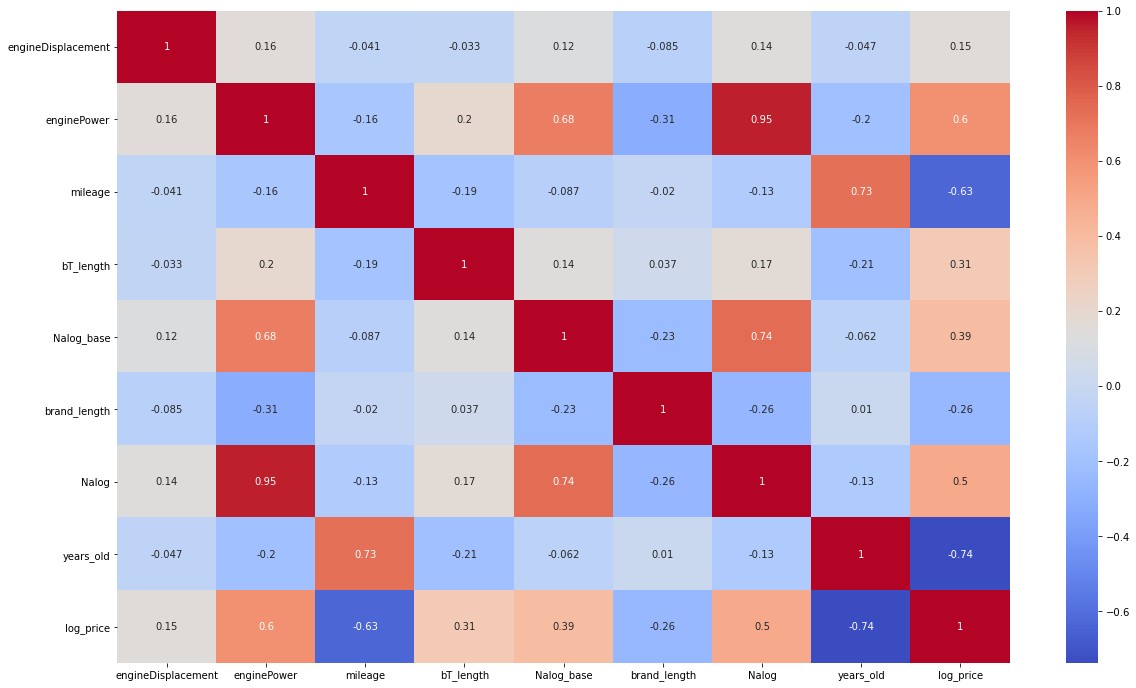

In [183]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [184]:
columns_d = ['brand_length']
train.drop(columns_d, axis=1, inplace=True)
test.drop(columns_d, axis=1, inplace=True)

In [186]:
columns = ['brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'bodyType2', 'bT_length',
       'Nalog', 'years_old', 'age_intervals']

In [211]:
df_train = train[columns]
df_test = test[columns]

In [212]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189450 entries, 0 to 27566
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   brand                189450 non-null  object  
 1   color                189450 non-null  object  
 2   engineDisplacement   189450 non-null  float64 
 3   enginePower          189450 non-null  int64   
 4   fuelType             189450 non-null  object  
 5   mileage              189450 non-null  int64   
 6   modelDate            189450 non-null  int64   
 7   model_name           189450 non-null  object  
 8   numberOfDoors        189450 non-null  int64   
 9   productionDate       189450 non-null  int64   
 10  vehicleTransmission  189450 non-null  object  
 11  vendor               189450 non-null  object  
 12  Владельцы            189450 non-null  category
 13  ПТС                  189450 non-null  object  
 14  Привод               189450 non-null  object  
 15  Р

In [213]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   brand                34686 non-null  object  
 1   color                34686 non-null  object  
 2   engineDisplacement   34686 non-null  float32 
 3   enginePower          34686 non-null  float64 
 4   fuelType             34686 non-null  object  
 5   mileage              34686 non-null  int64   
 6   modelDate            34686 non-null  int64   
 7   model_name           34686 non-null  object  
 8   numberOfDoors        34686 non-null  int64   
 9   productionDate       34686 non-null  int64   
 10  vehicleTransmission  34686 non-null  object  
 11  vendor               34686 non-null  object  
 12  Владельцы            34686 non-null  category
 13  ПТС                  34686 non-null  object  
 14  Привод               34686 non-null  object  
 15  Руль               

In [214]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   brand                34686 non-null  object  
 1   color                34686 non-null  object  
 2   engineDisplacement   34686 non-null  float32 
 3   enginePower          34686 non-null  float64 
 4   fuelType             34686 non-null  object  
 5   mileage              34686 non-null  int64   
 6   modelDate            34686 non-null  int64   
 7   model_name           34686 non-null  object  
 8   numberOfDoors        34686 non-null  int64   
 9   productionDate       34686 non-null  int64   
 10  vehicleTransmission  34686 non-null  object  
 11  vendor               34686 non-null  object  
 12  Владельцы            34686 non-null  category
 13  ПТС                  34686 non-null  object  
 14  Привод               34686 non-null  object  
 15  Руль               

In [215]:
y = train['price']

# Label Encoding


In [241]:
df_train['sample'] = 1 # трейн
df_test['sample'] = 0 # тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) 

<ipython-input-241-4e88541df81a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # трейн


In [217]:
data.isna().sum()

brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
vendor                 0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
bodyType2              0
bT_length              0
Nalog                  0
years_old              0
age_intervals          0
sample                 0
dtype: int64

In [218]:
for column in ['bodyType2', 'brand', 'color', 'fuelType', 'model_name', 'vendor', 'Владельцы', 'vehicleTransmission', 'Привод', 'age_intervals']:
    data[column] = data[column].astype('category').cat.codes

In [219]:
bin_cols = ['ПТС', 'Руль']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,...,Владельцы,ПТС,Привод,Руль,bodyType2,bT_length,Nalog,years_old,age_intervals,sample
0,8,14,1.2,105.0,0,74000,2013,710,5,2014,...,2,1,1,0,4,7,2625.0,7,1,0
1,8,17,1.6,110.0,0,60563,2017,710,5,2017,...,0,1,1,0,4,7,2750.0,4,1,0
2,8,13,1.8,152.0,0,88000,2013,954,5,2014,...,0,1,1,0,4,7,6840.0,7,1,0
3,8,7,1.6,110.0,0,95000,2013,710,5,2014,...,0,1,1,0,4,7,2750.0,7,1,0
4,8,1,1.8,152.0,0,58536,2008,710,5,2012,...,0,1,1,0,4,7,6840.0,9,2,0


In [220]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

Function to determine value of mape

In [221]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Train test split

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [223]:
np.log(y_train)

35293    12.785491
43487    12.206073
16756    15.287983
22445    13.975075
5453     13.304685
           ...    
33843    13.763165
17258    12.254863
46120    16.077065
61405    13.440089
35955    12.206073
Name: price, Length: 151560, dtype: float32

## CatBoost Regressor

In [ ]:
model = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', 
                          custom_metric=['R2', 'MAE'], silent=True)

In [ ]:
model.fit(X_train, np.log(y_train),   eval_set=(X_test, np.log(y_test)),
     verbose_eval=0,
     use_best_model=True,
     #plot=True
     )

In [ ]:
predict_test = np.exp(model.predict(X_test)) 
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_catboost.csv', index=False)


## GradientBoostingRegressor

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=5000)

In [ ]:
gb.fit(X_train, np.log(y_train))

In [ ]:
predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_1601gb.csv', index=False)


## RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,) 


In [ ]:
rfr.fit(X_train, np.log(y_train))

In [ ]:
predict_test = np.exp(rfr.predict(X_test))
predict_submission = np.exp(rfr.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_1602rfr.csv', index=False)


In [202]:
import xgboost as xgb

## XGBRegressor

In [224]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,booster='gbtree',
                          learning_rate= 0.01 ,max_depth=13, alpha=1,n_jobs=1,
                          n_estimators=5000)


In [226]:
xg_reg.fit(X_train, np.log(y_train))

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [227]:
predict_test = np.exp(xg_reg.predict(X_test)) 
predict_submission = np.exp(xg_reg.predict(X_sub))


In [228]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.73%


In [229]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_stackingxg.csv', index=False)


## StackingRegressor

Так как лучший результат дал нам именно GradientBoostingRegressor и XGBRegressor,я использовал этих 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [ ]:
estimators = [
    ('xg_reg', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,learning_rate=0.1, max_depth=12, alpha=1,n_estimators=5000)),
    ('gb', GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=12, n_estimators=5000))
]

In [ ]:
reg5 = StackingRegressor(estimators=estimators)


In [ ]:
reg5 = StackingRegressor(estimators=estimators)
reg5.fit(X_train, np.log(y_train))


In [ ]:
predict_test = np.exp(reg5.predict(X_test))
predict_submission = np.exp(reg5.predict(X_sub))


In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_stackingxg.csv', index=False)


In [244]:
sample_submission['price']

0        6.291267e+05
1        9.902330e+05
2        9.561991e+05
3        8.117656e+05
4        7.620947e+05
             ...     
34681    1.051706e+06
34682    2.502585e+06
34683    2.754434e+05
34684    1.114308e+06
34685    1.065745e+06
Name: price, Length: 34686, dtype: float32